In [1]:
# notebook to recreate Mingkang's simulation of qubit-SNAIL coupling gates
# using my refactored version of his code

In [2]:
import numpy as np
from qutip import Options
import qutip as qt
from functools import reduce
import yaml
from pathlib import Path
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumMode, QuantumSystem, Pulse
from quantum_logical.pulsesim.hamiltonian import QubitQubitSNAIL

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [3]:
# # Example instantiation of QuantumMode objects
# q2_mode = QuantumMode(name="Q2", freq=5.06167, dim=9, alpha=-0.161)
# q4_mode = QuantumMode(name="Q4", freq=4.54944, dim=9, alpha=-0.1275)
# snail_mode = QuantumMode(name="SNAIL", freq=4.27515, dim=10, g3=0.3)

# # Example instantiation of QuantumSystem object
# modes = [q2_mode, q4_mode, snail_mode]
# # couplings = {(mode1, mode2): g2}
# couplings = {(q2_mode, snail_mode): 54.67e-3, (q4_mode, snail_mode): 43.5e-3}
# quantum_sys = QuantumSystem(modes, couplings)
# quantum_sys

In [4]:
# Better, load from YAML file
# Ensure the correct path relative to the project root
project_root = Path("/home/evm9/quantum_logical")  # Adjust as necessary
yaml_file = (
    project_root / "src/quantum_logical/pulsesim/system_params/system_params.yaml"
)
quantum_system = QuantumSystem.from_yaml(yaml_file)

In [5]:
system_hamiltonian = QubitQubitSNAIL(quantum_system)
q1_mode = system_hamiltonian.q1_mode
q2_mode = system_hamiltonian.q2_mode

# prepare an initial state
psi0 = quantum_system.prepare_tensor_fock_state([(q2_mode, 1)])

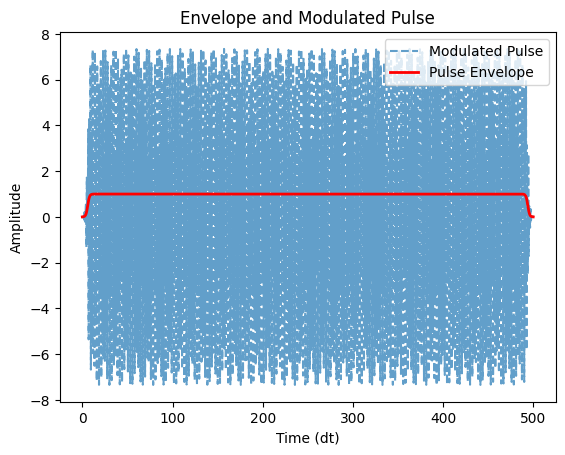

In [6]:
# Define experiment constants
# define frequency and amplitude ranges
# drive at qubit-qubit conversion with some detuning
width_d = 500
N = 50
flist = 2 * np.pi * (np.linspace(-0.01, 0.01, N) + abs(q1_mode.freq - q2_mode.freq))
alist = np.linspace(0, 30, N)
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 0, "width": width_d}}
t_list = np.linspace(0, width_d, 1000)

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 4)]
amp_p = alist[int(N / 4)]
pulse = Pulse(omega=omega_p, amp=amp_p)

# Plot the Gaussian pulse shape
pulse.plot_pulse(args["shape"], t_list, **args["shape_params"])

In [7]:
def simulation_task(freq_amp_tuple):
    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    H = system_hamiltonian.driven(pulse)
    solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts)
    final_state = solve_result.states[-1]
    ground_state_populations = [
        quantum_system.mode_population_expectation(final_state, mode, 0)
        for mode in quantum_system.modes
    ]
    return ground_state_populations


# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]

# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

# Process results
ground_state_populations = np.zeros((len(quantum_system.modes), len(alist), len(flist)))
for idx, (freq, amp) in enumerate(freq_amp_pairs):
    freq_idx = np.where(flist == freq)[0][0]
    amp_idx = np.where(alist == amp)[0][0]

    populations = results[idx]
    for k, pop in enumerate(populations):
        ground_state_populations[k, amp_idx, freq_idx] = pop

10.0%. Run time: 908.53s. Est. time left: 00:02:16:16
20.0%. Run time: 1817.10s. Est. time left: 00:02:01:08


KeyboardInterrupt: 

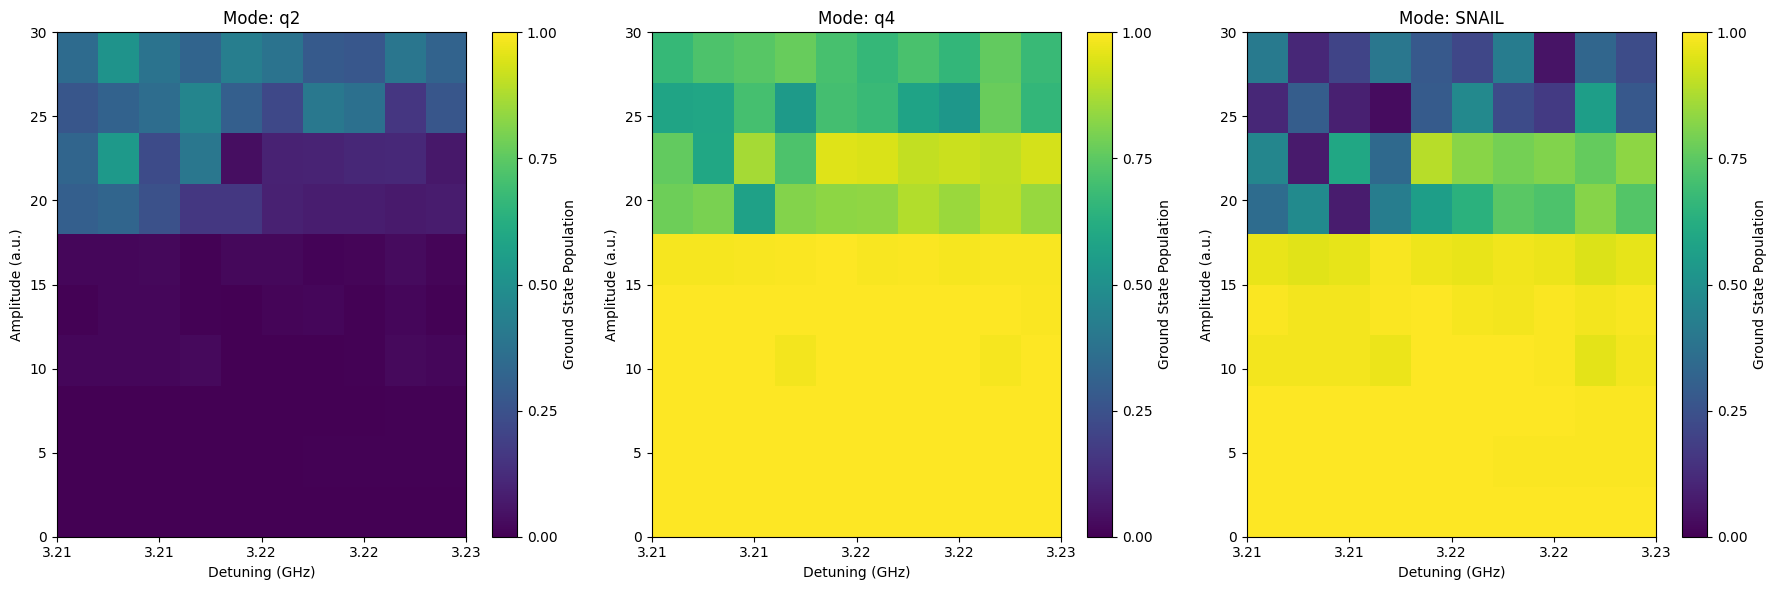

In [ ]:
# Prepare the plot
fig, axes = plt.subplots(
    1, len(quantum_system.modes), figsize=(len(quantum_system.modes) * 6, 6)
)

# Conversion factor from radian frequency to GHz
rad_to_GHz = 1 / (2 * np.pi)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# Plot data for each mode
for k, mode in enumerate(quantum_system.modes):
    im = axes[k].imshow(
        ground_state_populations[k],
        extent=[flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, alist[0], alist[-1]],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,  # Set color bar scale from 0.0 to 1.0
    )
    axes[k].set_title(f"Mode: {mode.name}")
    axes[k].set_xlabel("Detuning (GHz)")
    axes[k].set_ylabel("Amplitude (a.u.)")

    # Customize x-axis ticks
    xticks = np.linspace(flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, n_xticks)
    axes[k].set_xticks(xticks)
    axes[k].set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

    # Add color bar
    cbar = fig.colorbar(
        im, ax=axes[k], orientation="vertical", label="Ground State Population"
    )
    cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks

plt.tight_layout()
plt.show()

In [ ]:
# # create time-dependent Hamiltonian
# H = [system_hamiltonian.H, [snail_field, pulse.drive]]

# solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, progress_bar=p_bar)

# # solve_result.states[0]
# final_state = solve_result.states[-1]
# # print(final_state)

# # calculate expectation values
# # pi0 = quantum_system.mode_population_expectation(psi0, q2_mode, 0)
# # pf0 = quantum_system.mode_population_expectation(final_state, q2_mode, 0)
# # pi1 = quantum_system.mode_population_expectation(psi0, q2_mode, 1)
# # pf1 = quantum_system.mode_population_expectation(final_state, q2_mode, 1)

# # print(f"pi0 = {pi0:.3f}, pf0 = {pf0:.3f}")
# # print(f"pi1 = {pi1:.3f}, pf1 = {pf1:.3f}")